In [98]:
import pandas as pd
import numpy as np
import scipy
import unicodedata
import re
import contractions
import string
import distance
import glob
import joblib,pickle

#vis
#http://brandonrose.org/clustering
#https://medium.com/analytics-vidhya/machine-learning-4-unsupervised-learning-clustering-k-means-algorithm-dimensional-reduction-238a54e8cfcd

import matplotlib.pyplot as plt
import seaborn as sns 

from tqdm import tnrange


## for sentiment
from textblob import TextBlob

from bokeh.plotting import figure, show, output_notebook, output_file, save
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Category10,Category20

from wordcloud import WordCloud, ImageColorGenerator
from scipy.ndimage import gaussian_gradient_magnitude


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split

#spacy
import spacy
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nlp = spacy.load("en_core_web_sm")
nlp2 = spacy.load("en_core_web_md")
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
import textwrap
stops = stopwords.words('english')


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [136]:
def load_data(): 
    df_all = pd.read_csv('databrickssearcheswithwithoutclicks.csv')
    # Take a subset
    return df_all.loc[:, ["id","index_type","title","url","search_text","is_clicked"]]
df = load_data()

df.head()

,id,index_type,title,url,search_text,is_clicked
0,00000045-0de2-4ad5-9bc6-47c35b213b2f,aws_doc,SELECT,https://docs.databricks.com/spark/latest/spark...,time travel,True
1,0000d3c6-1967-49a3-9603-490249344096,aws_doc,Delta Live Tables cookbook,https://docs.databricks.com/data-engineering/d...,dlt.create_table,True
2,0001161c-fe72-4ba2-8cd1-70aa4e8d218f,aws_doc,INSERT OVERWRITE DIRECTORY,https://docs.databricks.com/spark/latest/spark...,insert overwrite ... partitions (a=x,True
3,000129d8-366a-4e57-a804-eef718557fad,NaN,NaN,NaN,complex,False
4,00015a7b-7545-4162-a8a8-fdb101426567,aws_doc,Dates and timestamps,https://docs.databricks.com/spark/latest/dataf...,date minus,True


In [137]:
df.dtypes

id             object
index_type     object
title          object
url            object
search_text    object
is_clicked       bool
dtype: object

In [138]:
num_cols = [col for col in df.columns if df[col].dtype != 'object']
print(num_cols)

['is_clicked']


In [139]:
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
print(cat_cols)

['id', 'index_type', 'title', 'url', 'search_text']


# Visualizing Missing Data

In [140]:
!pip install missingno

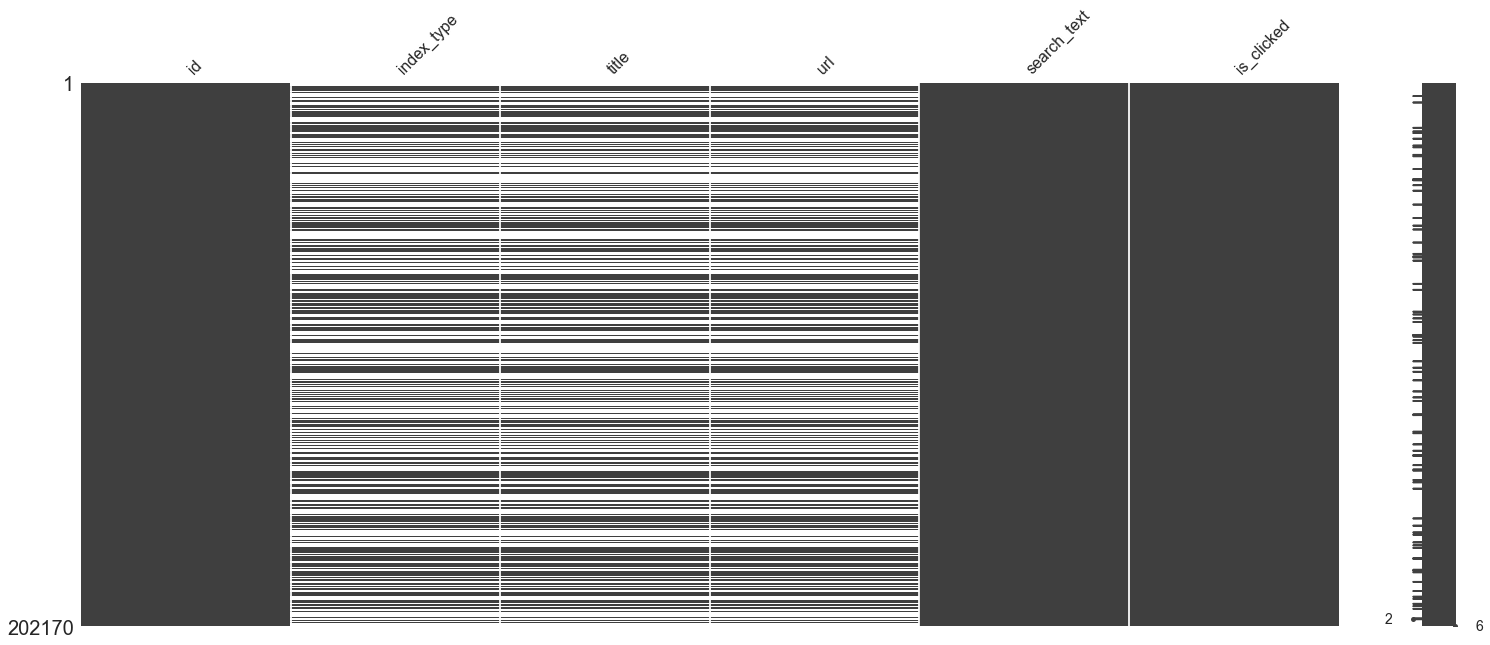

<Figure size 1080x648 with 0 Axes>

In [141]:
import missingno as msno
msno.matrix(df)
plt.figure(figsize = (15,9))
plt.show()

# Correlation Heatmap
Correlation heatmap measures nullity correlation between columns of the dataset. It shows how strongly the presence or absence of one feature affects the other.

Nullity correlation ranges from(-1 to 1):

-1 means if one column(attribute) is present, the other is almost certainly absent.
0 means there is no dependence between the columns(attributes).
1 means if one column(attributes) is present, the other is also certainly present.
Unlike in a familiar correlation heatmap, if you see here, many columns are missing. Those columns which are always full or always empty have no meaningful correlation and are removed from the visualization.

The heatmap is helpful for identifying data completeness correlations between attribute pairs, but it has the limited explanatory ability for broader relationships and no special support for really big datasets.

<AxesSubplot:>

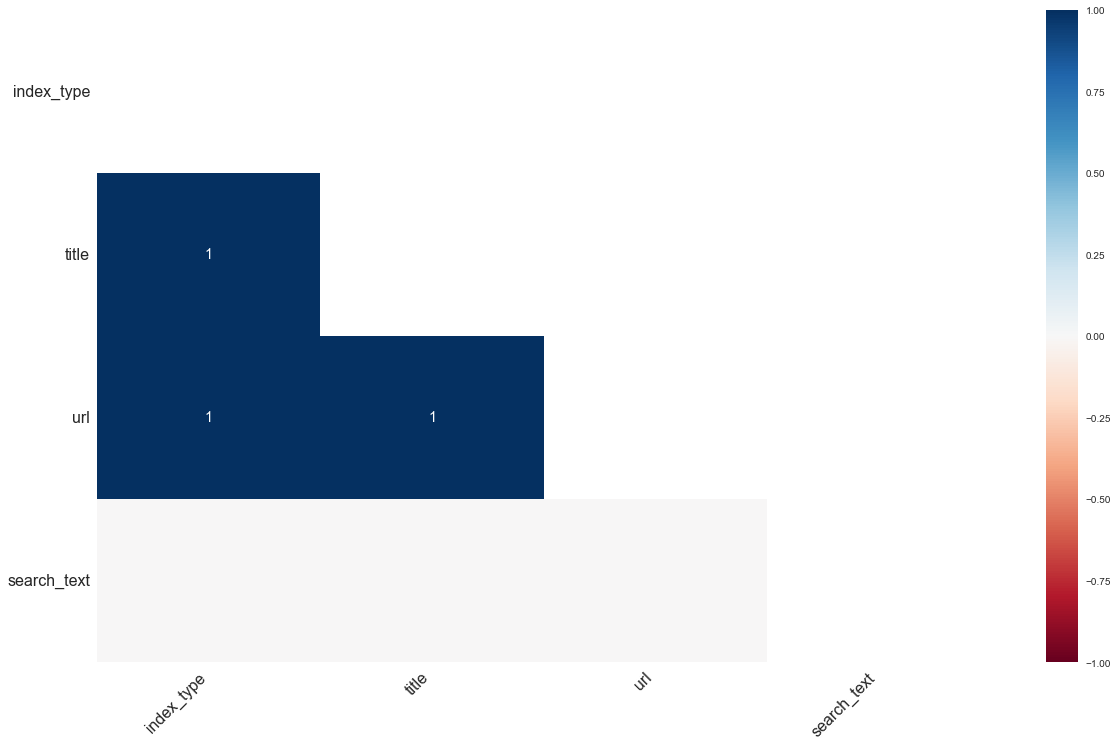

In [142]:
msno.heatmap(df, labels = True)

# Dendrogram

The dendrogram shows the hierarchical nullity relationship between columns. The dendrogram uses a hierarchical clustering algorithm against one another by their nullity correlation.

In [143]:
# Columns having missing values
missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
missing_columns

['index_type', 'title', 'url', 'search_text']

<AxesSubplot:>

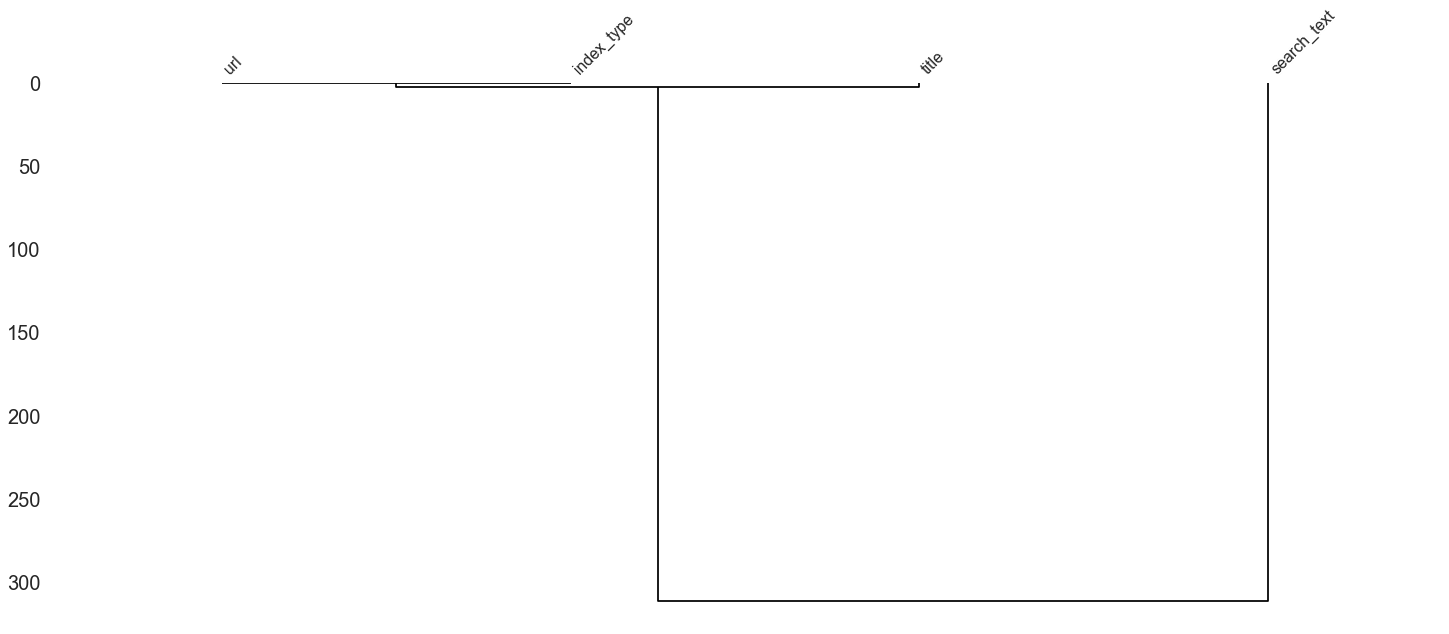

In [144]:
msno.dendrogram(df[missing_columns])

# Simple Numerical Summaries
Moving Forward lets try to analyse numerical summary of missing attributes. Simple numerical summaries are effective at identifying problematic predictors and samples when the data become too large to visually inspect.

In [145]:
def get_numerical_summary(df):
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    return missing_percent

In [146]:
missing_percent = get_numerical_summary(df)

index_type : 97049 (48.004%)
title : 97053 (48.006%)
url : 97049 (48.004%)
search_text : 174 (0.086%)


# FEATURE ENGINEERING

In [147]:
df.index_type.value_counts()

aws_doc               93610
feeditem_1             4392
gcp_docs               2425
aws kb                 2124
ms_azure               1044
case                    429
knowledge__kav          368
ms_kb                   158
message                 157
blog                    109
user                     84
apache_spark             76
gcp_kb                   69
feeditem                 63
issue                    10
collaborationgroup        3
Name: index_type, dtype: int64

In [148]:
cols = ['index_type']
df[cols] = df[cols].astype('category')

In [149]:
#https://datascienceparichay.com/article/pandas-emove-categories-from-a-categorical-column/#:~:text=You%20can%20use%20the%20Pandas,accessor%20to%20apply%20this%20function.&text=Pass%20the%20category%20or%20a,an%20argument%20to%20the%20function.
df["index_type"] = df["index_type"].cat.remove_categories(["aws_kb","feeditem_1","feeditem","case","knowledge__kav","message","blog","user","issue","collaborationgroup"])

In [150]:
# Remove URLs with fragments and parameters
df['url'] = df['url'].str.split('#').str[0]
df['url'] = df['url'].str.split('?').str[0]

In [151]:
df = df[df["title"].str.contains("Genie|genie|Gnie") == False]
df.reset_index(inplace = True)
del df['index']
df.head()

,id,index_type,title,url,search_text,is_clicked
0,00000045-0de2-4ad5-9bc6-47c35b213b2f,aws_doc,SELECT,https://docs.databricks.com/spark/latest/spark...,time travel,True
1,0000d3c6-1967-49a3-9603-490249344096,aws_doc,Delta Live Tables cookbook,https://docs.databricks.com/data-engineering/d...,dlt.create_table,True
2,0001161c-fe72-4ba2-8cd1-70aa4e8d218f,aws_doc,INSERT OVERWRITE DIRECTORY,https://docs.databricks.com/spark/latest/spark...,insert overwrite ... partitions (a=x,True
3,00015a7b-7545-4162-a8a8-fdb101426567,aws_doc,Dates and timestamps,https://docs.databricks.com/spark/latest/dataf...,date minus,True
4,000182cc-4c6b-4165-8b73-4e46665942b7,aws_doc,Delta Live Tables cookbook,https://docs.databricks.com/data-engineering/d...,live,True


In [152]:
df[df.search_text == "time travel"]
# df[df['search_text'].str.contains("time travel")]

,id,index_type,title,url,search_text,is_clicked
0,00000045-0de2-4ad5-9bc6-47c35b213b2f,aws_doc,SELECT,https://docs.databricks.com/spark/latest/spark...,time travel,True
3412,0824095e-366d-4010-9adb-aee70189dc4a,aws_doc,Work with time series feature tables,https://docs.databricks.com/applications/machi...,time travel,True
3829,092d9bee-0cae-44af-a952-cb54845c66c7,aws_doc,SELECT clause (Databricks SQL),https://docs.databricks.com/sql/language-manua...,time travel,True
4297,0a515a9f-74d8-4ff6-bb51-f49828953895,aws_doc,SELECT clause (Databricks SQL),https://docs.databricks.com/sql/language-manua...,time travel,True
5384,0cfd8737-3f9a-47f7-8282-03545899aa53,aws_doc,Work with time series feature tables,https://docs.databricks.com/applications/machi...,time travel,True
...,...,...,...,...,...,...
101150,f66737ae-0091-450f-b1b6-39b2c17c8dc7,aws_doc,Introduction,https://docs.databricks.com/delta/delta-intro....,time travel,True
101465,f72dc5a4-2534-43ba-beca-9e6ee9b7e896,aws_doc,SELECT,https://docs.databricks.com/spark/latest/spark...,time travel,True
103776,fccd3629-a75f-4368-9ab9-e5b570beefd3,aws_doc,SELECT clause (Databricks SQL),https://docs.databricks.com/sql/language-manua...,time travel,True
104488,fea48346-a8cb-4fad-b7c3-8049f1f29fa0,aws_doc,VACUUM (Databricks SQL),https://docs.databricks.com/sql/language-manua...,time travel,True


In [153]:
missing_percent3 = get_numerical_summary(df)

index_type : 5610 (5.34%)
search_text : 96 (0.091%)


# labels frequency with a bar plot for Index_type

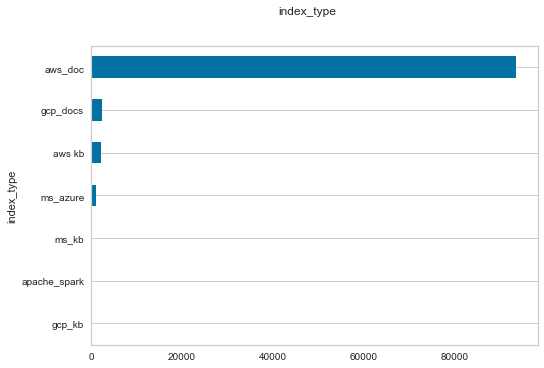

In [154]:
x = "index_type"
fig, ax = plt.subplots()
fig.suptitle(x, fontsize=12)
df[x].reset_index().groupby(x).count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

# finding urls with /feed

In [155]:
df.loc[df.url.str.contains("/feed") == True]

,id,index_type,title,url,search_text,is_clicked
2820,06cd3f03-782e-476a-9385-91391cfd91a4,NaN,Situs Mpo Game Slot Online &amp; Live Casino...,https://community.databricks.com/s/feed/0D53f0...,casino,True
6687,103d4e28-e50d-4267-812e-78765d6f91c2,NaN,Community Dashboard Contest Monday May...,https://community.databricks.com/s/feed/0D53f0...,community dashboard contest,True
9997,187346e3-9fe7-4ac8-89ba-a459480af316,NaN,Your guide to data and AI governance session...,https://community.databricks.com/s/feed/0D58Y0...,guide to data governance sessions,True
10695,1a325d44-4539-4fa0-9f5d-0ab2c6d4c529,NaN,Runtime 10.4 is available and is LTS. Fro...,https://community.databricks.com/s/feed/0D53f0...,low shuffle merge,True
13795,21b33f0f-f341-4f14-b762-f5f9b6a85fa8,NaN,Your guide to data and AI governance session...,https://community.databricks.com/s/feed/0D58Y0...,data governance,True
...,...,...,...,...,...,...
95033,e7902044-5533-4317-846d-cc74337112ed,NaN,Look what I just saw appearing in my notebook...,https://community.databricks.com/s/feed/0D53f0...,notebook,True
96964,ec4be7f4-fb32-4a10-9c15-a62195bc89ca,NaN,The Next Databricks Office Hours Our next Of...,https://community.databricks.com/s/feed/0D53f0...,office hours,True
97984,eeb0da88-61b5-4ae4-8999-85580b60fbd6,NaN,Software 2.0 is one of 10 most important tren...,https://community.databricks.com/s/feed/0D53f0...,software,True
101068,f64024fe-a8e2-41d6-8ccc-4bcf43c2cc0b,NaN,Become a Community Champion!,https://community.databricks.com/s/feed/0D58Y0...,badge,True


In [156]:
df['url'][0]

'https://docs.databricks.com/spark/latest/spark-sql/language-manual/sql-ref-syntax-qry-select.html'

# Removing from the rows with/feed

In [22]:
df = df[df.url.str.contains("/feed") != True]

# PRUNNING BY SETTING THRESHOLD

In [23]:
# def remove_shorter_query(data):
#     data["search_text"] = data["search_text"].apply(lambda x:str(x).split(' '))
#     data = data[data["search_text"].apply(lambda x:True if len(x) > 1 else False)]
#     data["search_text"] = data["search_text"].apply(lambda x:' '.join(x))
#     data = data.reset_index()
#     del data["index"]
    
#     return data

In [24]:
def remove_shorter_query(data,column,n):
    data[column] = data[column].apply(lambda x:str(x).split(' '))
    data = data[data[column].apply(lambda x:True if len(x) > n else False)]
    data[column] = data[column].apply(lambda x:' '.join(x))
    data = data.reset_index()
    del data["index"]
    
    return data

In [25]:
df = remove_shorter_query(df,"search_text",1)

/var/folders/7q/zq0k80m94v5408fgfvkddv880000gp/T/ipykernel_32715/127429367.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = data[column].apply(lambda x:' '.join(x))


In [26]:
missing_percent = get_numerical_summary(df)

index_type : 3941 (7.604%)


# Length Analysis
It’s important to have a look at the length of the text because it’s an easy calculation that can give a lot of insights. Maybe, for instance, we are lucky enough to discover that one category is systematically longer than another and the length would simply be the only feature needed to build the model. Unfortunately, this won’t be the case as news headlines have similar lengths, but it’s worth a try.

There are several length measures for text data. I will give some examples:

word count: counts the number of tokens in the text (separated by a space)
character count: sum the number of characters of each token
sentence count: count the number of sentences (separated by a period)
average word length: sum of words length divided by the number of words (character count/word count)
average sentence length: sum of sentences length divided by the number of sentences (word count/sentence count)

In [27]:
df['word_count'] = df["search_text"].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df["search_text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df['sentence_count'] = df["search_text"].apply(lambda x: len(str(x).split(".")))
df['avg_word_length'] = df['char_count'] / df['word_count']
df['avg_sentence_lenght'] = df['word_count'] / df['sentence_count']
df.head()

,index_type,title,url,search_text,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,aws_doc,SELECT,https://docs.databricks.com/spark/latest/spark...,time travel,2,10,1,5.0,2.00
1,aws_doc,INSERT OVERWRITE DIRECTORY,https://docs.databricks.com/spark/latest/spark...,insert overwrite ... partitions (a=x,5,32,4,6.4,1.25
2,aws_doc,Dates and timestamps,https://docs.databricks.com/spark/latest/dataf...,date minus,2,9,1,4.5,2.00
3,aws_doc,Structured Streaming,https://docs.databricks.com/spark/latest/struc...,autoscaling stream,2,17,1,8.5,2.00
4,aws_doc,Azure Data Lake Storage Gen2,https://docs.databricks.com/data/data-sources/...,mount datalake,2,13,1,6.5,2.00


In [28]:
df.index_type.value_counts()

aws_doc         44308
aws kb           1351
gcp_docs         1271
ms_azure          746
ms_kb             122
gcp_kb             46
apache_spark       45
Name: index_type, dtype: int64

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

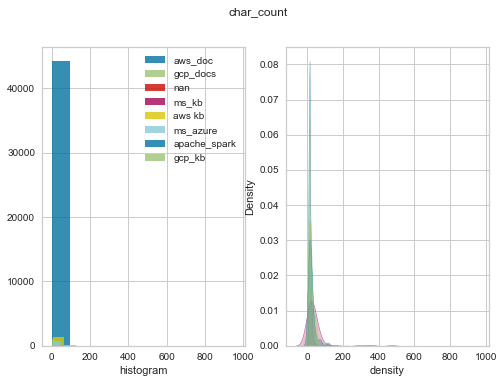

In [29]:
x, y = "char_count", "index_type"
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(x, fontsize=12)
for i in df[y].unique():
    sns.distplot(df[df[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(df[df[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(df[y].unique())
ax[1].grid(True)
plt.show()

# Sentiment Analysis
Sentiment analysis is the representation of subjective emotions of text data through numbers or classes. Calculating sentiment is one of the toughest tasks of NLP as natural language is full of ambiguity. For example, the phrase “This is so bad that it’s good” has more than one interpretation. A model could assign a positive signal to the word “good” and a negative one to the word “bad”, resulting in a neutral sentiment. That happens because the context is unknown.

The best approach would be training your own sentiment model that fits your data properly. When there is no enough time or data for that, one can use pre-trained models, like Textblob and Vader. Textblob, built on top of NLTK, is one of the most popular, it can assign polarity to words and estimate the sentiment of the whole text as an average. On the other hand, Vader (Valence aware dictionary and sentiment reasoner) is a rule-based model that works particularly well on social media data.

I am going to add a sentiment feature with Textblob:

In [30]:
df["sentiment"] = df['search_text'].apply(lambda x: 
                   TextBlob(x).sentiment.polarity)
df.head()

,index_type,title,url,search_text,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment
0,aws_doc,SELECT,https://docs.databricks.com/spark/latest/spark...,time travel,2,10,1,5.0,2.00,0.0
1,aws_doc,INSERT OVERWRITE DIRECTORY,https://docs.databricks.com/spark/latest/spark...,insert overwrite ... partitions (a=x,5,32,4,6.4,1.25,0.0
2,aws_doc,Dates and timestamps,https://docs.databricks.com/spark/latest/dataf...,date minus,2,9,1,4.5,2.00,-0.1
3,aws_doc,Structured Streaming,https://docs.databricks.com/spark/latest/struc...,autoscaling stream,2,17,1,8.5,2.00,0.0
4,aws_doc,Azure Data Lake Storage Gen2,https://docs.databricks.com/data/data-sources/...,mount datalake,2,13,1,6.5,2.00,0.0


In [31]:
df[df['sentiment'] > 0] 

,index_type,title,url,search_text,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment
5,aws_doc,Delta Live Tables,https://docs.databricks.com/data-engineering/d...,delta live tables,3,15,1,5.000000,3.0,0.136364
60,aws_doc,Delta Live Tables,https://docs.databricks.com/data-engineering/d...,delta live tables,3,15,1,5.000000,3.0,0.136364
62,aws_doc,Change data capture with Delta Live Tables,https://docs.databricks.com/data-engineering/d...,incremental live table,3,20,1,6.666667,3.0,0.136364
115,aws_doc,Delta Live Tables,https://docs.databricks.com/data-engineering/d...,delta live tables,3,15,1,5.000000,3.0,0.136364
126,aws_doc,Delta Live Tables cookbook,https://docs.databricks.com/data-engineering/d...,delta live cook,3,13,1,4.333333,3.0,0.136364
...,...,...,...,...,...,...,...,...,...,...
51761,aws_doc,ntile ranking window function,https://docs.databricks.com/spark/latest/spark...,greater than,2,11,1,5.500000,2.0,0.500000
51766,aws_doc,Identifiers,https://docs.databricks.com/spark/latest/spark...,unique identifier,2,16,1,8.000000,2.0,0.375000
51779,aws_doc,Delta Live Tables,https://docs.databricks.com/data-engineering/d...,live monitoring,2,14,1,7.000000,2.0,0.136364
51822,aws_doc,SELECT,https://docs.databricks.com/spark/latest/spark...,select top rows,3,13,1,4.333333,3.0,0.500000


/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

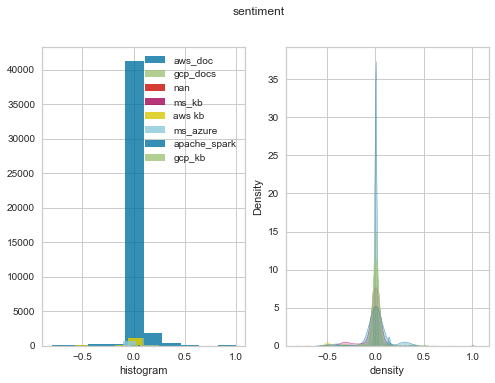

In [32]:
x, y = "sentiment", "index_type"
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(x, fontsize=12)
for i in df[y].unique():
    sns.distplot(df[df[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(df[df[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(df[y].unique())
ax[1].grid(True)
plt.show()

# Is there a pattern between categories and sentiment?
Most of the headlines have a neutral sentiment, except for aws_docs news that is skewed on the positive tail, and aws_kb that has a spike on the negative tail.

In [157]:
# Group by page
grouped_df = df.groupby(['url']).agg({'search_text':list})
 
# Join all queries in a single string
#https://bobbyhadz.com/blog/python-typeerror-sequence-item-0-expected-str-instance-float-found
grouped_df['queries'] = grouped_df['search_text'].apply(lambda x: ' '.join(map(str,x)))
 
# Create a list of grouped queries
# for each page. 
queries = list(grouped_df['queries'])


In [160]:
#queries

In [35]:
tfidf_vec = TfidfVectorizer(min_df=0.005, 
                            stop_words=stops) 
data_tfidf = tfidf_vec.fit_transform(queries).todense()
tfidf_df = pd.DataFrame(
    data_tfidf,
    columns=tfidf_vec.get_feature_names(),
    index=grouped_df.index
    )
 
tfidf_df
# pca = PCA( 0.95, random_state=2140)
# data_pca = pca.fit_transform(data_tfidf)

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,10,academy,access,account,accounts,acl,add,adding,adls,admin,...,week,widget,window,within,workspace,write,writing,xml,year,zone
url,,,,,,,,,,,,,,,,,,,,,
https://community.databricks.com/s/group/0F93f0000004CyfCAE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://community.databricks.com/s/group/0F98Y000000PpJLSA0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://community.databricks.com/s/profile/0053f000000WJxHAAW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://community.databricks.com/s/profile/0053f000000WOk8AAG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://community.databricks.com/s/profile/0053f000000WSJuAAO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://spark.apache.org/docs/latest/streaming-custom-receivers.html,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://spark.apache.org/docs/latest/streaming-kafka-0-10-integration.html,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://spark.apache.org/docs/latest/structured-streaming-kafka-integration.html,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
#We also reduce the dimensionality of the TF-IDF vectors using PCA. We choose to keep 95% of data original variance.

In [37]:
pca = PCA( 0.95, random_state=2140)
data_pca = pca.fit_transform(data_tfidf)

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [38]:
print( f"TF-IDF dimension - {data_tfidf.shape[1]}" )
print( f"TF-IDF + PCA dimension - {data_pca.shape[1]}" )

TF-IDF dimension - 420
TF-IDF + PCA dimension - 326


In [39]:
# data_pca.explained_variance_ratio_

In [40]:
N_WORDS = 30
mean_data_tfidf = np.array( data_tfidf.mean( axis=0 ) ).flatten()
vocabulary = tfidf_vec.get_feature_names()
words_id = np.flip( mean_data_tfidf.argsort()[-N_WORDS:] )

word_val_data = [ (vocabulary[id], mean_data_tfidf[id]) for id in words_id ]
word_val_data = pd.DataFrame(word_val_data, columns=['words','values'])

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Top-30 most important words')

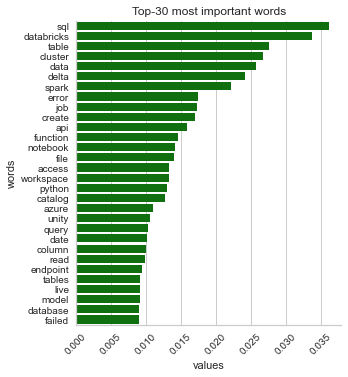

In [41]:
g = sns.catplot(data=word_val_data, color='green',
                 x='values', y='words', kind='bar' )
g.ax.tick_params(axis='x', rotation=45)
g.ax.set_title( f"Top-{N_WORDS} most important words" )

# Clustering with K-means
Selecting number of clusters

In [42]:
cluster_sizes = range(2, 20+1)
kmeans_models = [ KMeans(i, n_init=20, random_state=2140) for i in cluster_sizes ]
cluster_score = []

for kmeans in kmeans_models:
    y = kmeans.fit_predict(data_pca)
    score = silhouette_score(data_pca, y)
    cluster_score.append( ( kmeans.n_clusters, score) )

cluster_score=np.array(cluster_score)

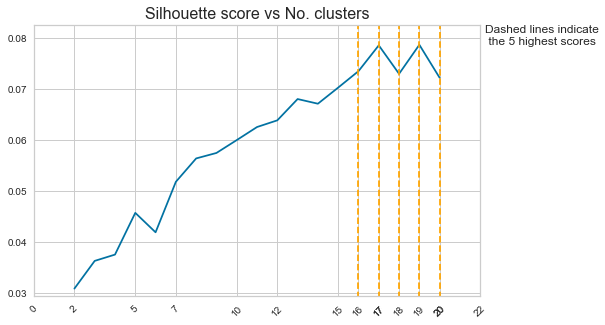

In [43]:
scores = cluster_score[:, 1]
clusters = cluster_score[:, 0]
max_score_clusters = []

fig, ax = plt.subplots( figsize=(8,5) )
ax = sns.lineplot( x=clusters, y=scores, ax=ax )
ax.set_title("Silhouette score vs No. clusters", fontsize=16)

for i in np.argsort( scores )[-5:]:
  ax.vlines(clusters[i], 0, 1, linestyles='--', colors='orange')
  max_score_clusters.append( clusters[i] )

ax.text(1.01, 1, f"Dashed lines indicate\n the {len(max_score_clusters)} highest scores",
        transform=ax.transAxes, ha='left', va='top')

xticks = ax.get_xticks().astype(int)
xticks = np.append(xticks, max_score_clusters)
ax.set_xticks( xticks )
ax.tick_params(axis='x', rotation=45)

ax.set_ylim( [ 0.95*min(scores), 1.05*max(scores) ] )
ax.set_xlim( [ 0, max(clusters)+2 ] )

plt.show()

In [44]:
n_clusters= 13
kmeans_model = KMeans(n_clusters =13, n_init=20, random_state=2140)
y = kmeans_model.fit_predict(data_pca)

# Results visualization
Silhouette samples

In [45]:
sample_scores = silhouette_samples( data_pca, y )
sample_scores_df =  pd.DataFrame( data = {'Cluster':y, 'Silhouette':sample_scores} )
sample_scores_df = sample_scores_df.reset_index()
sample_scores_df=sample_scores_df.sort_values('Silhouette', ascending=False)

In [46]:
sample_scores_df

,index,Cluster,Silhouette
4155,4155,7,0.692168
4151,4151,7,0.692168
4241,4241,7,0.692168
4154,4154,7,0.692168
4156,4156,7,0.692168
...,...,...,...
2295,2295,6,-0.147865
5075,5075,6,-0.171963
2806,2806,6,-0.179163
4059,4059,6,-0.207058


In [47]:
kmeans_pca_scale = KMeans(n_clusters=13, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(data_pca)

In [48]:
# assign predicted clusters
labels = kmeans_pca_scale.labels_
#print(len(labels)) 
# create a dataframe that contains 
# clusters matched to pages and their queries 
mapping = list(zip(labels, grouped_df.index, queries))
clusters = pd.DataFrame(mapping, columns=['cluster','url','search_text'])
clusters.head()
clusters.head(10)

,cluster,url,search_text
0,5,https://community.databricks.com/s/group/0F93f...,chicago area
1,5,https://community.databricks.com/s/group/0F98Y...,north texas
2,5,https://community.databricks.com/s/profile/005...,josephine ho
3,5,https://community.databricks.com/s/profile/005...,kesav kolla
4,5,https://community.databricks.com/s/profile/005...,saurabh verma
5,5,https://community.databricks.com/s/profile/005...,chris shehu
6,5,https://community.databricks.com/s/profile/005...,hubert dudek
7,5,https://community.databricks.com/s/profile/005...,chandan nandy
8,5,https://community.databricks.com/s/profile/005...,edicks nelson
9,5,https://community.databricks.com/s/profile/005...,iso certification


# BIGRAMS

In [49]:
def find_bigrams(input_list):
    return list(zip(input_list, input_list[1:]))

In [50]:
from nltk import pos_tag, word_tokenize

In [51]:
from collections import Counter
from nltk.tokenize import word_tokenize
 
my_dict1 = {}
n_clusters = clusters['cluster'].unique()
n=3 
# for each cluster
for c in n_clusters: 
    # 1
    asset = clusters[clusters['cluster'] == c] 
    asset = asset['search_text']
    m_asset = ' '.join(asset)
    # 2
    tokens = word_tokenize(m_asset)
    # 3
    words = [word for word in tokens if not word in stops]
    # 4
    bigrams = find_bigrams(words)
    bigrams = list(map(' '.join, bigrams))
    # 5
    counts = Counter(bigrams)
    # 6
    most_common = counts.most_common(4)
    most_freq = [bigram[0] for bigram in most_common]
    # 7
    my_dict1[c] = ','.join(most_freq)
     
my_dict1

{5: 'feature store,create database,store feature,database create',
 10: 'query history,history query,query query,sql query',
 0: 'cluster policy,policy cluster,cluster cluster,cluster policies',
 3: 'jobs api,api jobs,import notebook,job api',
 11: 'create table,delta live,table create,live tables',
 2: 'apache spark,spark ui,spark spark,spark sql',
 4: 'data type,change data,data types,data feed',
 7: 'unity catalog,catalog unity,public preview,catalog public',
 12: 'model serving,model registry,serving model,registry model',
 6: 'create workspace,workspace api,workspace workspace,workspace create',
 9: 'sql endpoint,endpoint sql,databricks sql,sql sql',
 8: 'databricks runtime,runtime databricks,release notes,notes release',
 1: 'json json,read json,nested json,json read'}

In [52]:
# Add number of article per cluster
val_count = clusters['cluster'].value_counts()
for i in range(len(val_count)):
    my_dict1[i] += f' ({val_count[i]})'

In [53]:
 my_dict1

{5: 'feature store,create database,store feature,database create (3352)',
 10: 'query history,history query,query query,sql query (66)',
 0: 'cluster policy,policy cluster,cluster cluster,cluster policies (210)',
 3: 'jobs api,api jobs,import notebook,job api (216)',
 11: 'create table,delta live,table create,live tables (332)',
 2: 'apache spark,spark ui,spark spark,spark sql (209)',
 4: 'data type,change data,data types,data feed (170)',
 7: 'unity catalog,catalog unity,public preview,catalog public (109)',
 12: 'model serving,model registry,serving model,registry model (89)',
 6: 'create workspace,workspace api,workspace workspace,workspace create (98)',
 9: 'sql endpoint,endpoint sql,databricks sql,sql sql (249)',
 8: 'databricks runtime,runtime databricks,release notes,notes release (54)',
 1: 'json json,read json,nested json,json read (54)'}

# Use the Clustered Data

In [54]:
# show_k = 6
 
# print('Cluster number: ', show_k)
# print('\nTop bigrams: ')
# print(my_dict1[show_k])
# print('\nTitles in the cluster: ')
# pages = clusters['search_text'][clusters['cluster'] == show_k]
# for page in pages:
#     print(page)

# Most Important words in each cluster

In [55]:
def most_important_words(data_tfidf, y, topn=10):

    n_clusters = len(np.unique(y))
    result = []
    for i in range(n_clusters):
        ith_cluter_word_sum = np.mean(data_tfidf[np.argwhere(y==i).flatten()], axis=0)

        word_ids = np.array( np.argsort( ith_cluter_word_sum )[0, -topn:] )
        word_ids = word_ids.reshape( -1 )
        result = result + [ (i, id, ith_cluter_word_sum[0, id] ) for id in word_ids ]

    return result

In [56]:
word_cluster_df = pd.DataFrame( most_important_words( data_tfidf, y, topn=5 ), columns=["Cluster", "WordId", "Score"] )
word_cluster_df["Word"] = word_cluster_df["WordId"].apply( lambda id: tfidf_vec.get_feature_names()[id] )
word_cluster_df = word_cluster_df.sort_values( "Score", ascending=False )
word_cluster_df.head()

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Cluster,WordId,Score,Word
74,14,91,0.644575,date
29,5,213,0.603457,log
9,1,84,0.581151,data
54,10,16,0.567869,api
69,13,72,0.549266,create


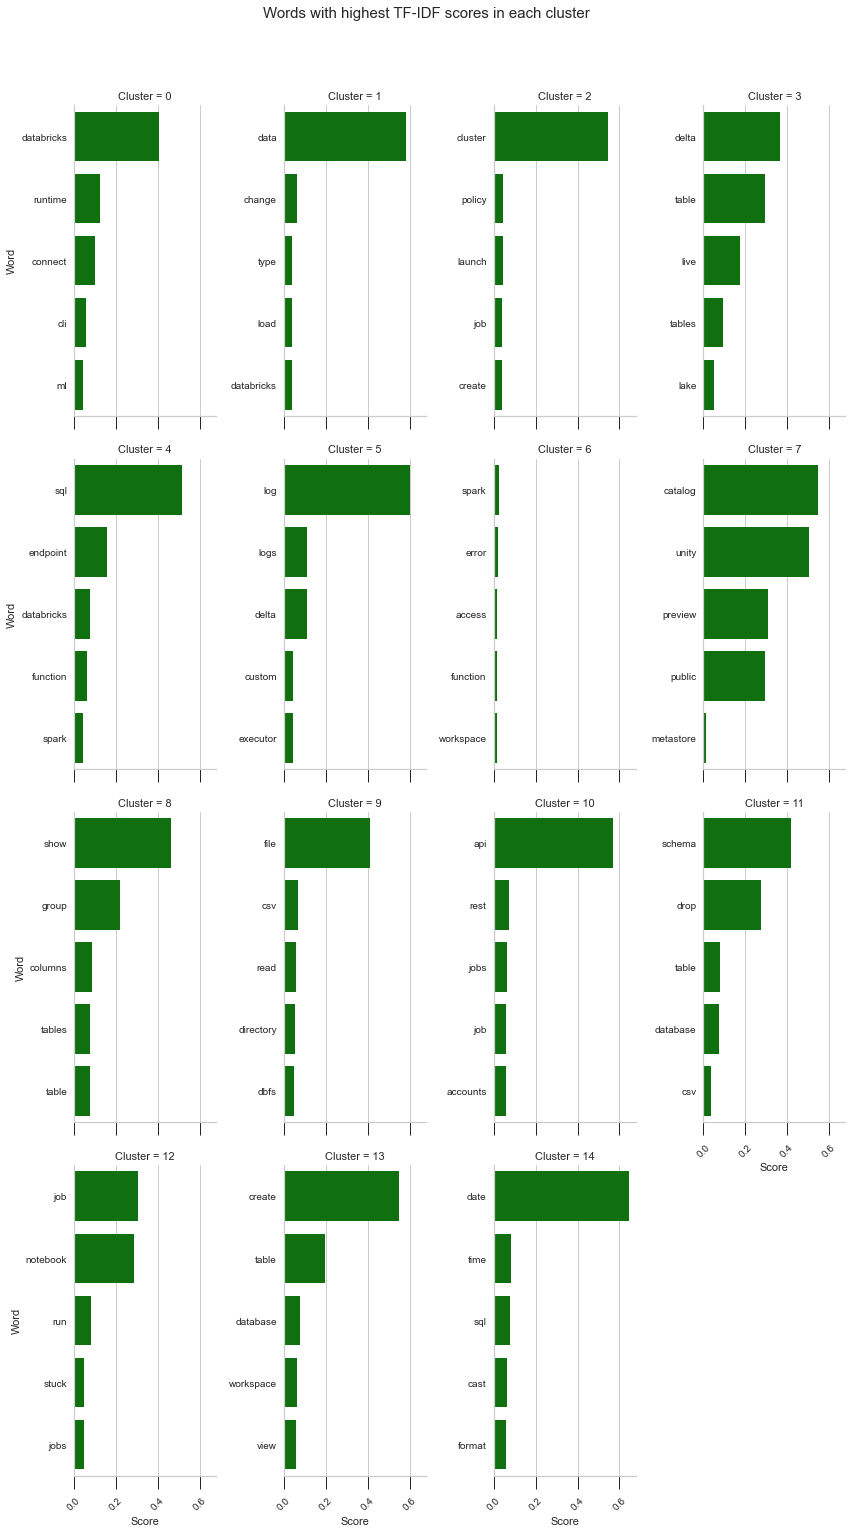

In [57]:
g = sns.catplot(x="Score", y="Word", col="Cluster", data=word_cluster_df, 
                sharey=False, col_wrap=4, kind="bar",
                color = 'green', aspect=.6)
[ ax.tick_params(axis='x', rotation=45, size=13) for ax in g.axes.flatten() ]
g.fig.suptitle( "Words with highest TF-IDF scores in each cluster", y = 1.05, fontsize=15 )
plt.show()

# 2D view of clusters and data with U-Map

In [58]:
!pip install umap-learn

In [62]:
import umap
output_notebook()

Loading BokehJS ...

In [63]:
umap_red = umap.UMAP(n_neighbors=13, metric='correlation', 
                     random_state=214)
data_2d = umap_red.fit_transform( data_pca )

In [64]:
data_2d_df = pd.DataFrame( data={"x":data_2d[:, 0], 
                                 "y":data_2d[:, 1], 
                                 "Cluster":y,
                                 "Silhouette":sample_scores } )


c_pallete = list(Category20[15])
c_pallete[7], c_pallete[0] = c_pallete[0], c_pallete[7]

data_2d_df['colors'] = [ c_pallete[i] for i in data_2d_df['Cluster']]
data_2d_df['search_text'] = df['search_text']
# #Limiting the text's size
data_2d_df['search_text'] = data_2d_df['search_text'].apply( lambda s: s[:100]+'...' if len(s)>100 else s )

data_2d_df, _,_,_ = train_test_split(data_2d_df, data_2d_df, train_size=4500, stratify=data_2d_df['Cluster'])

data_2d_cdf = ColumnDataSource(data_2d_df)


In [65]:
fig = figure(
    title='UMAP 2D projection of the points and clusters',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset', 'save')
)

fig.add_tools(HoverTool(tooltips="""
                                      <div>
                                        <span style='font-size: 10px; color: @colors'>@ementa</span>
                                        <span style='font-size: 10px'>cluster - </span>
                                        <span style='font-size: 10px'>@Cluster ;</span>
                                        <span style='font-size: 10px'>index - </span>
                                        <span style='font-size: 10px'>$index ;</span>
                                        <span style='font-size: 10px'>silhouette: </span>
                                        <span style='font-size: 10px'>@Silhouette</span>
                                      </div>
                                 """)
              )

fig.circle('x','y', source=data_2d_cdf, color='colors', 
           legend_group="Cluster",
           line_alpha=0.6, fill_alpha=0.6, size=2)

show(fig)
save(fig, "UMAP2D.html")

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/bokeh/io/saving.py:142: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/bokeh/io/saving.py:154: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'/Users/ankush.singal/Databricks_issues_CS_clustering /UMAP2D.html'

# Saving Models

In [ ]:
pickle.dump(tfidf_vec, open('tfidf_vec.pickle', 'wb'))

In [ ]:
pickle.dump(pca, open('pca.pickle', 'wb'))

In [ ]:
pickle.dump(kmeans_model, open('kmeans_model.pickle', 'wb'))

# convert urls to pdfs

In [ ]:
clusters.url[4]

In [ ]:
clusters.head()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(data_pca)

In [ ]:
def getind(c):
     return clusters[clusters.search_text == c].index.tolist()

In [ ]:
def getscene(i):
     return clusters[clusters.index == i].search_text.tolist()

In [ ]:
similar = list(enumerate(cosine_sim[i]))
similar[:5]

In [ ]:
#https://medium.com/@nisha.imagines/nlp-with-python-text-clustering-based-on-content-similarity-cae4ecffba3c

In [ ]:
similar_list=[]
disimilar_list=[]
for m in similar:
    t = getscene(m[0])
    if m[1] > 0.15:
        similar_list.append(t)
    else:
        disimilar_list.append(t)

In [ ]:
pd.DataFrame(similar_list, columns = ['similar_list'])